<>:112: SyntaxWarning: invalid escape sequence '\M'
<>:112: SyntaxWarning: invalid escape sequence '\M'
C:\Users\KITAYIKUYO\AppData\Local\Temp\ipykernel_20448\2146563583.py:112: SyntaxWarning: invalid escape sequence '\M'
  model_path = f"D:\MechineLearning_Project\AutoCellCounting\model\model_{batch_size}_{epochs}_{learning_rate}.pth"
C:\Users\KITAYIKUYO\AppData\Local\Temp\ipykernel_20448\2146563583.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are exp

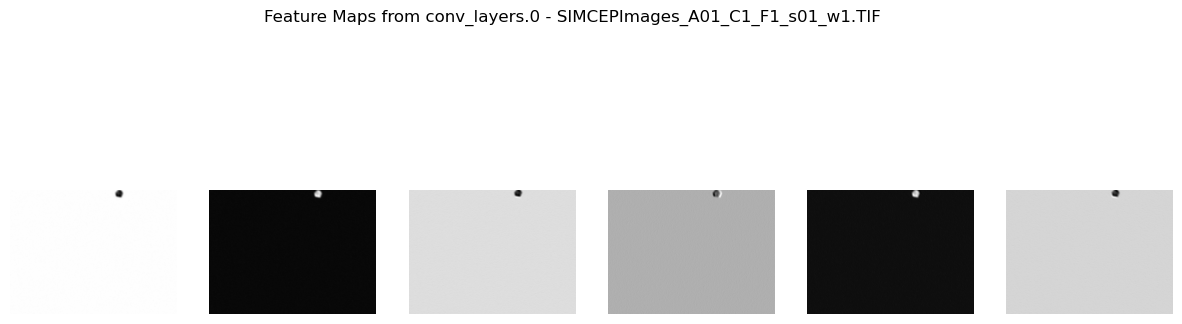

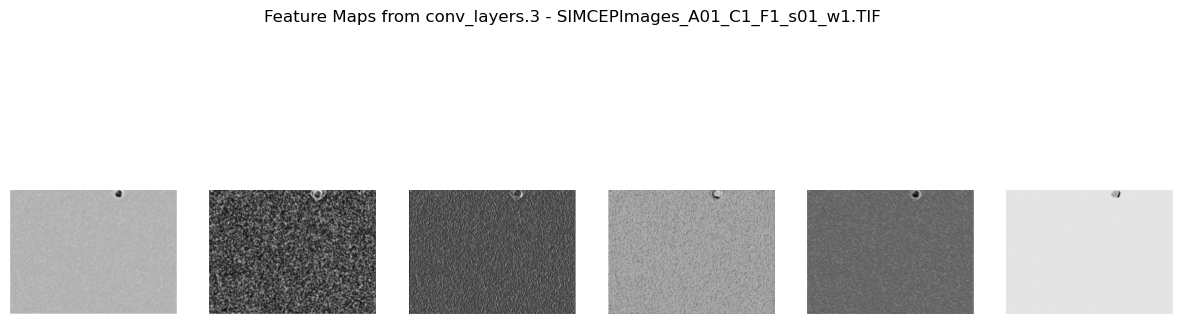

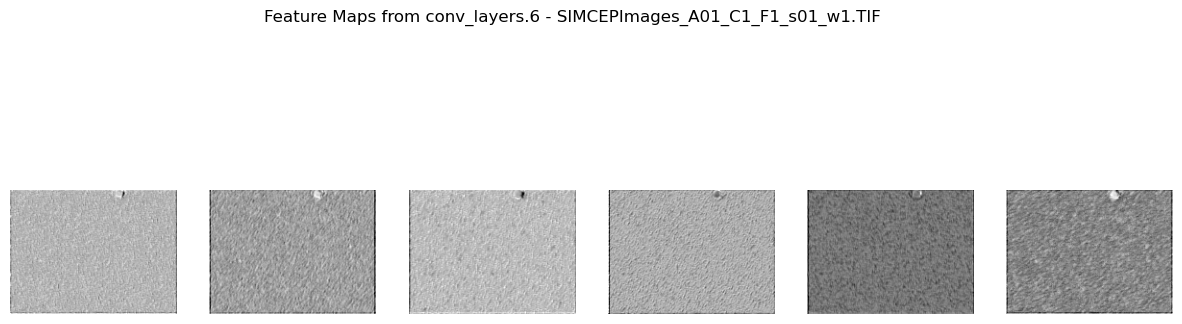

In [2]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import os

# --- 定义 CNN 模型 ---
class CellCountingCNN(nn.Module):
    def __init__(self):
        super(CellCountingCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 65 * 87, 128),  # 这里的64 * 65 * 87需要根据输入图像尺寸计算
            nn.ReLU(),
            nn.Linear(128, 1)  # 输出细胞数量
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# --- 自定义数据集类 ---
class CellDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".TIF")]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("L")  # 转换为灰度图
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]  # 返回图像及文件名，便于可视化

# --- 重新实例化模型并加载权重 ---
def load_model(model_path, device):
    model = CellCountingCNN()  # 重新实例化模型
    model.load_state_dict(torch.load(model_path, map_location=device))  # 加载参数
    model.to(device)
    model.eval()
    return model

# --- 获取卷积层输出（仅 batch[0]） ---
def get_conv_layer_outputs(model, image_tensor):
    outputs = []
    hooks = []

    def hook_fn(module, input, output):
        outputs.append(output.detach())  # 存储每一层的特征图

    # 递归注册所有 Conv2d 层的 hook
    def register_hooks(module):
        for layer in module.children():
            if isinstance(layer, nn.Conv2d):
                hooks.append(layer.register_forward_hook(hook_fn))
            elif isinstance(layer, nn.Sequential) or isinstance(layer, nn.Module):
                register_hooks(layer)

    register_hooks(model)

    # 仅使用 batch[0] 进行前向传播
    with torch.no_grad():
        model(image_tensor[0].unsqueeze(0))  # 仅处理 batch 内的第一张图

    # 取消 hook
    for hook in hooks:
        hook.remove()

    return outputs

# --- 可视化卷积层特征图 ---
def visualize_feature_maps(feature_maps, layer_names, image_name):
    for i, fmap in enumerate(feature_maps):
        fmap = fmap.squeeze(0)  # 移除 batch 维度
        num_channels = fmap.shape[0]

        fig, axes = plt.subplots(1, min(6, num_channels), figsize=(15, 5))
        fig.suptitle(f"Feature Maps from {layer_names[i]} - {image_name}")

        for j in range(min(6, num_channels)):
            axes[j].imshow(fmap[j].cpu().numpy(), cmap='gray')
            axes[j].axis('off')

        plt.show()

if __name__ == "__main__":
    
    # 参数
    batch_size = 32
    epochs = 199
    learning_rate = 0.001
    model_path = f"D:\MechineLearning_Project\AutoCellCounting\model\model_{batch_size}_{epochs}_{learning_rate}.pth"
    image_dir = "D:/MechineLearning_Project/AutoCellCounting/database/test"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 数据预处理
    transform = transforms.Compose([
        transforms.Resize((520, 696)),
        transforms.ToTensor(),
    ])

    # 创建数据加载器
    dataset = CellDataset(image_dir, transform)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=False)  # batch_size > 1

    # 加载模型
    model = load_model(model_path, device)

    # 获取 batch[0] 图像
    images, image_names = next(iter(dataloader))
    images = images.to(device)

    # 获取卷积层特征图
    feature_maps = get_conv_layer_outputs(model, images)

    # 获取所有卷积层名称
    conv_layers = [name for name, layer in model.named_modules() if isinstance(layer, nn.Conv2d)]

    # 可视化 batch[0] 的特征图
    visualize_feature_maps(feature_maps, conv_layers, image_names[0])
